# Laboratorio 2 - Pronóstico en Series de Tiempo Largas (ETT)
## TiDE: Time-series Dense Encoder

### Paper: Long-term Forecasting with TiDE: Time-series Dense Encoder
**Autores:** Abhimanyu Das, Weihao Kong, Andrew Leach, Shaan Mathur, Rajat Sen, Rose Yu

---

## Contenido
1. Introducción y Configuración
2. Carga y Preprocesamiento de Datos
3. Implementación del Modelo TiDE
4. Entrenamiento y Evaluación
5. Experimentos y Resultados
6. Visualizaciones y Análisis

## 1. Introducción y Configuración

In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Device (soporte para CUDA, MPS y CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# Semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Using device: mps


### Configuración del Experimento

In [12]:
# Configuración según el laboratorio
CONFIG = {
    'datasets': ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'],
    'look_back': 96,
    'horizons': [24, 48, 96, 192, 336, 720],
    'target': 'OT',  # Oil Temperature
    'train_ratio': 0.7,
    'val_ratio': 0.1,
    'test_ratio': 0.2,
}

# Hiperparámetros del modelo TiDE (según paper)
HPARAMS = {
    'ETTh1': {
        'hidden_size': 256,
        'num_encoder_layers': 2,
        'num_decoder_layers': 2,
        'decoder_output_dim': 8,
        'temporal_decoder_hidden': 128,
        'temporal_width': 4,
        'dropout': 0.3,
        'layer_norm': True,
        'learning_rate': 3.82e-5,
        'batch_size': 512,
        'epochs': 100,
        'patience': 10,
        'use_revin': True
    },
    'ETTh2': {
        'hidden_size': 512,
        'num_encoder_layers': 2,
        'num_decoder_layers': 2,
        'decoder_output_dim': 32,
        'temporal_decoder_hidden': 16,
        'temporal_width': 4,
        'dropout': 0.2,
        'layer_norm': True,
        'learning_rate': 2.24e-4,
        'batch_size': 512,
        'epochs': 100,
        'patience': 10,
        'use_revin': True
    },
    'ETTm1': {
        'hidden_size': 1024,
        'num_encoder_layers': 1,
        'num_decoder_layers': 1,
        'decoder_output_dim': 8,
        'temporal_decoder_hidden': 128,
        'temporal_width': 4,
        'dropout': 0.5,
        'layer_norm': True,
        'learning_rate': 8.39e-5,
        'batch_size': 512,
        'epochs': 100,
        'patience': 10,
        'use_revin': False
    },
    'ETTm2': {
        'hidden_size': 512,
        'num_encoder_layers': 2,
        'num_decoder_layers': 2,
        'decoder_output_dim': 16,
        'temporal_decoder_hidden': 128,
        'temporal_width': 4,
        'dropout': 0.0,
        'layer_norm': True,
        'learning_rate': 2.52e-4,
        'batch_size': 512,
        'epochs': 100,
        'patience': 10,
        'use_revin': True
    }
}

print("Configuración cargada exitosamente")

Configuración cargada exitosamente


## 2. Carga y Preprocesamiento de Datos

In [13]:
def download_ett_data():
    """Descarga los datasets ETT si no existen"""
    import urllib.request
    
    data_dir = Path('data')
    data_dir.mkdir(exist_ok=True)
    
    base_url = 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/'
    datasets = ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv']
    
    for dataset in datasets:
        file_path = data_dir / dataset
        if not file_path.exists():
            print(f'Descargando {dataset}...')
            url = base_url + dataset
            urllib.request.urlretrieve(url, file_path)
            print(f'{dataset} descargado exitosamente')
        else:
            print(f'{dataset} ya existe')

# Descargar datos
download_ett_data()

ETTh1.csv ya existe
ETTh2.csv ya existe
ETTm1.csv ya existe
ETTm2.csv ya existe


In [14]:
def create_time_features(df):
    """
    Crea features temporales a partir de la columna 'date'
    Normaliza a escala [-0.5, 0.5] como en el paper
    """
    df['date'] = pd.to_datetime(df['date'])
    
    # 8 features temporales (como en el paper)
    df['minute'] = ((df['date'].dt.minute / 59.0) - 0.5).astype(np.float32)
    df['hour'] = ((df['date'].dt.hour / 23.0) - 0.5).astype(np.float32)
    df['dayofweek'] = ((df['date'].dt.dayofweek / 6.0) - 0.5).astype(np.float32)
    df['day'] = ((df['date'].dt.day / 31.0) - 0.5).astype(np.float32)
    df['dayofyear'] = ((df['date'].dt.dayofyear / 365.0) - 0.5).astype(np.float32)
    df['month'] = ((df['date'].dt.month / 12.0) - 0.5).astype(np.float32)
    
    # Week of year puede dar problemas con tipos, forzamos conversión
    week_values = df['date'].dt.isocalendar().week.astype(float)
    df['weekofyear'] = ((week_values / 52.0) - 0.5).astype(np.float32)
    
    # Feature cíclica para día de la semana
    df['is_weekend'] = ((df['date'].dt.dayofweek >= 5).astype(float) - 0.5).astype(np.float32)
    
    time_features = ['minute', 'hour', 'dayofweek', 'day', 'dayofyear', 'month', 'weekofyear', 'is_weekend']
    
    return df, time_features


def load_ett_data(dataset_name):
    """Carga y preprocesa un dataset ETT"""
    file_path = Path('data') / f'{dataset_name}.csv'
    df = pd.read_csv(file_path)
    
    # Crear features temporales
    df, time_features = create_time_features(df)
    
    # Columnas de datos (excluir 'date')
    data_cols = [col for col in df.columns if col != 'date' and col not in time_features]
    
    print(f"\n{dataset_name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Data columns: {data_cols}")
    print(f"  Time features: {time_features}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    
    return df, data_cols, time_features


# Cargar todos los datasets
datasets_info = {}
for dataset_name in CONFIG['datasets']:
    df, data_cols, time_features = load_ett_data(dataset_name)
    datasets_info[dataset_name] = {
        'df': df,
        'data_cols': data_cols,
        'time_features': time_features
    }


ETTh1:
  Shape: (17420, 16)
  Data columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
  Time features: ['minute', 'hour', 'dayofweek', 'day', 'dayofyear', 'month', 'weekofyear', 'is_weekend']
  Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00

ETTh2:
  Shape: (17420, 16)
  Data columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
  Time features: ['minute', 'hour', 'dayofweek', 'day', 'dayofyear', 'month', 'weekofyear', 'is_weekend']
  Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00

ETTm1:
  Shape: (69680, 16)
  Data columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
  Time features: ['minute', 'hour', 'dayofweek', 'day', 'dayofyear', 'month', 'weekofyear', 'is_weekend']
  Date range: 2016-07-01 00:00:00 to 2018-06-26 19:45:00

ETTm2:
  Shape: (69680, 16)
  Data columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
  Time features: ['minute', 'hour', 'dayofweek', 'day', 'dayofyear', 'month', 'weekofyear', 'is_weekend']
  Dat

In [15]:
class RevIN(nn.Module):
    """Reversible Instance Normalization (opcional según dataset)"""
    def __init__(self, num_features, eps=1e-5, affine=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(num_features))
            self.affine_bias = nn.Parameter(torch.zeros(num_features))
    
    def forward(self, x, mode='norm'):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        return x
    
    def _get_statistics(self, x):
        # x: (batch_size, seq_len, num_features)
        self.mean = x.mean(dim=1, keepdim=True).detach()
        self.std = torch.sqrt(x.var(dim=1, keepdim=True, unbiased=False) + self.eps).detach()
    
    def _normalize(self, x):
        x = (x - self.mean) / self.std
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x
    
    def _denormalize(self, x):
        if self.affine:
            x = (x - self.affine_bias) / self.affine_weight
        x = x * self.std + self.mean
        return x


class TimeSeriesDataset(Dataset):
    """Dataset para series de tiempo con ventanas deslizantes"""
    
    def __init__(self, data, target_col, time_features, look_back, horizon, 
                 scaler_mean=None, scaler_std=None):
        self.data = data
        self.target_col = target_col
        self.time_features = time_features
        self.look_back = look_back
        self.horizon = horizon
        
        # Normalización (usando estadísticas del conjunto de entrenamiento)
        if scaler_mean is None:
            self.scaler_mean = data[target_col].mean()
            self.scaler_std = data[target_col].std()
        else:
            self.scaler_mean = scaler_mean
            self.scaler_std = scaler_std
        
        # Datos normalizados
        self.data_norm = data.copy()
        self.data_norm[target_col] = (data[target_col] - self.scaler_mean) / self.scaler_std
        
    def __len__(self):
        return len(self.data) - self.look_back - self.horizon + 1
    
    def __getitem__(self, idx):
        # Look-back (pasado)
        lookback_start = idx
        lookback_end = idx + self.look_back
        
        # Horizonte (futuro)
        horizon_start = lookback_end
        horizon_end = horizon_start + self.horizon
        
        # Target (OT normalizado)
        y_past = torch.FloatTensor(
            self.data_norm[self.target_col].iloc[lookback_start:lookback_end].values
        )
        y_future = torch.FloatTensor(
            self.data_norm[self.target_col].iloc[horizon_start:horizon_end].values
        )
        
        # Covariables temporales (pasado + futuro)
        x_past = torch.FloatTensor(
            self.data_norm[self.time_features].iloc[lookback_start:lookback_end].values
        )
        x_future = torch.FloatTensor(
            self.data_norm[self.time_features].iloc[horizon_start:horizon_end].values
        )
        
        return {
            'y_past': y_past,
            'y_future': y_future,
            'x_past': x_past,
            'x_future': x_future
        }


def create_datasets(df, target_col, time_features, look_back, horizon, 
                   train_ratio=0.7, val_ratio=0.1):
    """Crea datasets de train, val y test con split temporal"""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train_data = df.iloc[:train_end]
    val_data = df.iloc[:val_end]  # Incluye train para tener contexto
    test_data = df.iloc[:]
    
    # Crear dataset de train para calcular estadísticas
    train_dataset = TimeSeriesDataset(
        train_data, target_col, time_features, look_back, horizon
    )
    
    # Usar estadísticas de train para val y test
    val_dataset = TimeSeriesDataset(
        val_data, target_col, time_features, look_back, horizon,
        scaler_mean=train_dataset.scaler_mean,
        scaler_std=train_dataset.scaler_std
    )
    
    test_dataset = TimeSeriesDataset(
        test_data, target_col, time_features, look_back, horizon,
        scaler_mean=train_dataset.scaler_mean,
        scaler_std=train_dataset.scaler_std
    )
    
    # Ajustar índices para validación y test
    val_dataset.data = val_data.iloc[train_end - look_back:]
    val_dataset.data_norm = val_dataset.data.copy()
    val_dataset.data_norm[target_col] = (val_dataset.data[target_col] - train_dataset.scaler_mean) / train_dataset.scaler_std
    
    test_dataset.data = test_data.iloc[val_end - look_back:]
    test_dataset.data_norm = test_dataset.data.copy()
    test_dataset.data_norm[target_col] = (test_dataset.data[target_col] - train_dataset.scaler_mean) / train_dataset.scaler_std
    
    return train_dataset, val_dataset, test_dataset

print("Clases de preprocesamiento definidas exitosamente")

Clases de preprocesamiento definidas exitosamente


## 3. Implementación del Modelo TiDE

In [16]:
class ResidualBlock(nn.Module):
    """Bloque residual: MLP con skip connection"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1, use_layer_norm=True):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.use_layer_norm = use_layer_norm
        
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(output_dim)
        
        # Skip connection (proyección si las dimensiones no coinciden)
        if input_dim != output_dim:
            self.skip = nn.Linear(input_dim, output_dim)
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        # MLP path
        out = torch.relu(self.linear1(x))
        out = self.dropout(self.linear2(out))
        
        # Skip connection
        out = out + self.skip(x)
        
        if self.use_layer_norm:
            out = self.layer_norm(out)
        
        return out


class TiDEModel(nn.Module):
    """Time-series Dense Encoder (TiDE) Model"""
    
    def __init__(self, 
                 look_back,
                 horizon,
                 num_covariates,
                 hidden_size=256,
                 num_encoder_layers=2,
                 num_decoder_layers=2,
                 decoder_output_dim=8,
                 temporal_decoder_hidden=128,
                 temporal_width=4,
                 dropout=0.1,
                 use_layer_norm=True,
                 use_revin=False):
        super().__init__()
        
        self.look_back = look_back
        self.horizon = horizon
        self.num_covariates = num_covariates
        self.hidden_size = hidden_size
        self.decoder_output_dim = decoder_output_dim
        self.temporal_width = temporal_width
        self.use_revin = use_revin
        
        # Reversible Instance Normalization (opcional)
        if use_revin:
            self.revin = RevIN(1)
        
        # 1. Feature Projection (por time-step)
        # Proyecta covariables de num_covariates a temporal_width dimensiones
        self.feature_projection = ResidualBlock(
            num_covariates, 
            hidden_size, 
            temporal_width, 
            dropout, 
            use_layer_norm
        )
        
        # 2. Dense Encoder
        # Input: [y_past; x_past_projected; x_future_projected]
        encoder_input_dim = look_back + (look_back + horizon) * temporal_width
        
        encoder_layers = []
        for i in range(num_encoder_layers):
            if i == 0:
                encoder_layers.append(
                    ResidualBlock(encoder_input_dim, hidden_size, hidden_size, dropout, use_layer_norm)
                )
            else:
                encoder_layers.append(
                    ResidualBlock(hidden_size, hidden_size, hidden_size, dropout, use_layer_norm)
                )
        self.encoder = nn.Sequential(*encoder_layers)
        
        # 3. Dense Decoder
        decoder_layers = []
        for i in range(num_decoder_layers):
            if i == num_decoder_layers - 1:
                # Última capa: output es horizon * decoder_output_dim
                decoder_layers.append(
                    ResidualBlock(hidden_size, hidden_size, horizon * decoder_output_dim, dropout, use_layer_norm)
                )
            else:
                decoder_layers.append(
                    ResidualBlock(hidden_size, hidden_size, hidden_size, dropout, use_layer_norm)
                )
        self.decoder = nn.Sequential(*decoder_layers)
        
        # 4. Temporal Decoder (por time-step del horizonte)
        self.temporal_decoder = ResidualBlock(
            decoder_output_dim + temporal_width,
            temporal_decoder_hidden,
            1,  # Output: predicción para un time-step
            dropout,
            use_layer_norm
        )
        
        # 5. Global Residual Connection (linear)
        self.global_residual = nn.Linear(look_back, horizon)
    
    def forward(self, y_past, x_past, x_future):
        """
        Args:
            y_past: (batch_size, look_back, 1)
            x_past: (batch_size, look_back, num_covariates)
            x_future: (batch_size, horizon, num_covariates)
        Returns:
            predictions: (batch_size, horizon, 1)
        """
        batch_size = y_past.size(0)
        
        # Aplicar RevIN al pasado si está habilitado
        if self.use_revin:
            y_past = self.revin(y_past, mode='norm')
        
        # 1. Feature Projection
        # Proyectar covariables (pasado y futuro) independientemente por time-step
        x_past_proj = self.feature_projection(x_past)  # (batch, look_back, temporal_width)
        x_future_proj = self.feature_projection(x_future)  # (batch, horizon, temporal_width)
        
        # 2. Encoder
        # Concatenar: [y_past flattened; x_past_proj flattened; x_future_proj flattened]
        y_past_flat = y_past.squeeze(-1)  # (batch, look_back)
        x_past_flat = x_past_proj.reshape(batch_size, -1)  # (batch, look_back * temporal_width)
        x_future_flat = x_future_proj.reshape(batch_size, -1)  # (batch, horizon * temporal_width)
        
        encoder_input = torch.cat([y_past_flat, x_past_flat, x_future_flat], dim=1)
        encoding = self.encoder(encoder_input)  # (batch, hidden_size)
        
        # 3. Decoder
        decoder_output = self.decoder(encoding)  # (batch, horizon * decoder_output_dim)
        decoder_output = decoder_output.reshape(batch_size, self.horizon, self.decoder_output_dim)
        
        # 4. Temporal Decoder
        # Para cada time-step del horizonte, combinar con covariables proyectadas
        predictions = []
        for t in range(self.horizon):
            # Concatenar decoded vector con covariables proyectadas del time-step
            temporal_input = torch.cat([decoder_output[:, t, :], x_future_proj[:, t, :]], dim=1)
            pred_t = self.temporal_decoder(temporal_input)  # (batch, 1)
            predictions.append(pred_t)
        
        predictions = torch.stack(predictions, dim=1)  # (batch, horizon, 1)
        
        # 5. Global Residual Connection
        residual = self.global_residual(y_past_flat).unsqueeze(-1)  # (batch, horizon, 1)
        predictions = predictions + residual
        
        # Aplicar RevIN inverso si está habilitado
        if self.use_revin:
            predictions = self.revin(predictions, mode='denorm')
        
        return predictions

print("Modelo TiDE implementado exitosamente")

Modelo TiDE implementado exitosamente


## 4. Entrenamiento y Evaluación

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        y_past = batch['y_past'].unsqueeze(-1).to(device)
        y_future = batch['y_future'].unsqueeze(-1).to(device)
        x_past = batch['x_past'].to(device)
        x_future = batch['x_future'].to(device)
        
        optimizer.zero_grad()
        
        predictions = model(y_past, x_past, x_future)
        loss = criterion(predictions, y_future)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device, denorm_fn=None):
    """Evalúa el modelo y calcula MSE y MAE"""
    model.eval()
    total_mse = 0
    total_mae = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating', leave=False):
            y_past = batch['y_past'].unsqueeze(-1).to(device)
            y_future = batch['y_future'].unsqueeze(-1).to(device)
            x_past = batch['x_past'].to(device)
            x_future = batch['x_future'].to(device)
            
            predictions = model(y_past, x_past, x_future)
            
            # Desnormalizar si se proporciona función
            if denorm_fn is not None:
                predictions_denorm = denorm_fn(predictions)
                y_future_denorm = denorm_fn(y_future)
            else:
                predictions_denorm = predictions
                y_future_denorm = y_future
            
            # MSE y MAE
            mse = torch.mean((predictions_denorm - y_future_denorm) ** 2)
            mae = torch.mean(torch.abs(predictions_denorm - y_future_denorm))
            
            total_mse += mse.item()
            total_mae += mae.item()
            
            all_predictions.append(predictions_denorm.cpu())
            all_targets.append(y_future_denorm.cpu())
    
    avg_mse = total_mse / len(data_loader)
    avg_mae = total_mae / len(data_loader)
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_mse, avg_mae, all_predictions, all_targets


def train_model(model, train_loader, val_loader, hparams, device, dataset_name, horizon):
    """Entrena el modelo con early stopping"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])
    
    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=hparams['epochs'], eta_min=1e-6
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    # Función para desnormalizar
    def denorm_fn(x):
        return x * val_loader.dataset.scaler_std + val_loader.dataset.scaler_mean
    
    print(f"\nEntrenando {dataset_name} - Horizonte {horizon}")
    print("=" * 60)
    
    for epoch in range(hparams['epochs']):
        # Entrenar
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validar
        val_mse, val_mae, _, _ = evaluate(model, val_loader, criterion, device, denorm_fn)
        val_losses.append(val_mse)
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            patience_counter = 0
            # Guardar mejor modelo
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{hparams['epochs']} - "
                  f"Train Loss: {train_loss:.6f} - "
                  f"Val MSE: {val_mse:.6f} - Val MAE: {val_mae:.6f} - "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        if patience_counter >= hparams['patience']:
            print(f"Early stopping en época {epoch+1}")
            break
    
    # Restaurar mejor modelo
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

print("Funciones de entrenamiento definidas exitosamente")

Funciones de entrenamiento definidas exitosamente


## 5. Experimentos y Resultados

In [18]:
# Almacenar todos los resultados
all_results = []
all_histories = {}

# Experimentos para cada dataset y horizonte
for dataset_name in CONFIG['datasets']:
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")
    
    df = datasets_info[dataset_name]['df']
    time_features = datasets_info[dataset_name]['time_features']
    hparams = HPARAMS[dataset_name]
    
    all_histories[dataset_name] = {}
    
    for horizon in CONFIG['horizons']:
        print(f"\n{'-'*80}")
        print(f"Horizonte: {horizon}")
        print(f"{'-'*80}")
        
        # Crear datasets
        train_dataset, val_dataset, test_dataset = create_datasets(
            df, CONFIG['target'], time_features, CONFIG['look_back'], horizon,
            CONFIG['train_ratio'], CONFIG['val_ratio']
        )
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        # DataLoaders
        train_loader = DataLoader(
            train_dataset, batch_size=hparams['batch_size'], shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=hparams['batch_size'], shuffle=False
        )
        test_loader = DataLoader(
            test_dataset, batch_size=hparams['batch_size'], shuffle=False
        )
        
        # Crear modelo
        model = TiDEModel(
            look_back=CONFIG['look_back'],
            horizon=horizon,
            num_covariates=len(time_features),
            hidden_size=hparams['hidden_size'],
            num_encoder_layers=hparams['num_encoder_layers'],
            num_decoder_layers=hparams['num_decoder_layers'],
            decoder_output_dim=hparams['decoder_output_dim'],
            temporal_decoder_hidden=hparams['temporal_decoder_hidden'],
            temporal_width=hparams['temporal_width'],
            dropout=hparams['dropout'],
            use_layer_norm=hparams['layer_norm'],
            use_revin=hparams['use_revin']
        ).to(device)
        
        # Contar parámetros
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Parámetros del modelo: {num_params:,}")
        
        # Entrenar
        model, train_losses, val_losses = train_model(
            model, train_loader, val_loader, hparams, device, dataset_name, horizon
        )
        
        # Evaluar en test
        def denorm_fn(x):
            return x * test_dataset.scaler_std + test_dataset.scaler_mean
        
        test_mse, test_mae, predictions, targets = evaluate(
            model, test_loader, nn.MSELoss(), device, denorm_fn
        )
        
        print(f"\n{'*'*60}")
        print(f"RESULTADOS FINALES - {dataset_name} - Horizonte {horizon}")
        print(f"Test MSE: {test_mse:.6f}")
        print(f"Test MAE: {test_mae:.6f}")
        print(f"{'*'*60}")
        
        # Guardar resultados
        all_results.append({
            'Dataset': dataset_name,
            'Horizon': horizon,
            'MSE': test_mse,
            'MAE': test_mae,
            'Num_Params': num_params
        })
        
        # Guardar historial
        all_histories[dataset_name][horizon] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'predictions': predictions,
            'targets': targets
        }

print("\n" + "="*80)
print("TODOS LOS EXPERIMENTOS COMPLETADOS")
print("="*80)


DATASET: ETTh1

--------------------------------------------------------------------------------
Horizonte: 24
--------------------------------------------------------------------------------
Train samples: 12075
Val samples: 1718
Test samples: 3462
Parámetros del modelo: 798,298

Entrenando ETTh1 - Horizonte 24


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.160363 - Val MSE: 4.247166 - Val MAE: 1.599813 - LR: 3.73e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.140048 - Val MSE: 3.705466 - Val MAE: 1.488275 - LR: 3.46e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.128742 - Val MSE: 3.412103 - Val MAE: 1.423782 - LR: 3.05e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.121935 - Val MSE: 3.239211 - Val MAE: 1.384466 - LR: 2.53e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.117471 - Val MSE: 3.131036 - Val MAE: 1.359791 - LR: 1.96e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.114837 - Val MSE: 3.063798 - Val MAE: 1.344363 - LR: 1.39e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.113135 - Val MSE: 3.023275 - Val MAE: 1.335010 - LR: 8.67e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.112585 - Val MSE: 3.000013 - Val MAE: 1.329681 - LR: 4.55e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.111893 - Val MSE: 2.989090 - Val MAE: 1.327169 - LR: 1.91e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.111498 - Val MSE: 2.984288 - Val MAE: 1.326063 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 24
Test MSE: 4.119793
Test MAE: 1.554062
************************************************************

--------------------------------------------------------------------------------
Horizonte: 48
--------------------------------------------------------------------------------
Train samples: 12051
Val samples: 1694
Test samples: 3438
Parámetros del modelo: 948,850

Entrenando ETTh1 - Horizonte 48


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.185188 - Val MSE: 5.141285 - Val MAE: 1.761188 - LR: 3.73e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.168687 - Val MSE: 4.685099 - Val MAE: 1.673687 - LR: 3.46e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.159723 - Val MSE: 4.452941 - Val MAE: 1.628238 - LR: 3.05e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.155247 - Val MSE: 4.320683 - Val MAE: 1.602144 - LR: 2.53e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.151427 - Val MSE: 4.242003 - Val MAE: 1.586602 - LR: 1.96e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.150050 - Val MSE: 4.191951 - Val MAE: 1.576694 - LR: 1.39e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.148982 - Val MSE: 4.162260 - Val MAE: 1.570836 - LR: 8.67e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.147895 - Val MSE: 4.145376 - Val MAE: 1.567514 - LR: 4.55e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.147725 - Val MSE: 4.136873 - Val MAE: 1.565830 - LR: 1.91e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.147780 - Val MSE: 4.133497 - Val MAE: 1.565163 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 48
Test MSE: 5.711395
Test MAE: 1.845239
************************************************************

--------------------------------------------------------------------------------
Horizonte: 96
--------------------------------------------------------------------------------
Train samples: 12003
Val samples: 1646
Test samples: 3390
Parámetros del modelo: 1,249,954

Entrenando ETTh1 - Horizonte 96


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.218161 - Val MSE: 6.728795 - Val MAE: 2.009705 - LR: 3.73e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.203014 - Val MSE: 6.194404 - Val MAE: 1.917429 - LR: 3.46e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.195079 - Val MSE: 5.935482 - Val MAE: 1.871615 - LR: 3.05e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.190094 - Val MSE: 5.792845 - Val MAE: 1.846228 - LR: 2.53e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.187103 - Val MSE: 5.709293 - Val MAE: 1.831587 - LR: 1.96e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.186048 - Val MSE: 5.661466 - Val MAE: 1.823296 - LR: 1.39e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.184833 - Val MSE: 5.630193 - Val MAE: 1.817890 - LR: 8.67e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.184348 - Val MSE: 5.614395 - Val MAE: 1.815179 - LR: 4.55e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.183979 - Val MSE: 5.606464 - Val MAE: 1.813823 - LR: 1.91e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.183715 - Val MSE: 5.603161 - Val MAE: 1.813255 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 96
Test MSE: 7.816205
Test MAE: 2.162978
************************************************************

--------------------------------------------------------------------------------
Horizonte: 192
--------------------------------------------------------------------------------
Train samples: 11907
Val samples: 1550
Test samples: 3294
Parámetros del modelo: 1,852,162

Entrenando ETTh1 - Horizonte 192


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.242646 - Val MSE: 10.066413 - Val MAE: 2.539452 - LR: 3.73e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.228513 - Val MSE: 9.456653 - Val MAE: 2.456357 - LR: 3.46e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.221902 - Val MSE: 9.109986 - Val MAE: 2.407774 - LR: 3.05e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.218527 - Val MSE: 8.907235 - Val MAE: 2.378805 - LR: 2.53e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.215669 - Val MSE: 8.781051 - Val MAE: 2.360591 - LR: 1.96e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.215928 - Val MSE: 8.702514 - Val MAE: 2.349044 - LR: 1.39e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.214197 - Val MSE: 8.659096 - Val MAE: 2.342627 - LR: 8.67e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.214454 - Val MSE: 8.630854 - Val MAE: 2.338469 - LR: 4.55e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.213055 - Val MSE: 8.617262 - Val MAE: 2.336421 - LR: 1.91e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.213194 - Val MSE: 8.611767 - Val MAE: 2.335615 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 192
Test MSE: 9.069725
Test MAE: 2.323137
************************************************************

--------------------------------------------------------------------------------
Horizonte: 336
--------------------------------------------------------------------------------
Train samples: 11763
Val samples: 1406
Test samples: 3150
Parámetros del modelo: 2,755,474

Entrenando ETTh1 - Horizonte 336


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.260864 - Val MSE: 8.095538 - Val MAE: 2.250897 - LR: 3.73e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.249314 - Val MSE: 7.896878 - Val MAE: 2.218865 - LR: 3.46e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.243428 - Val MSE: 7.799316 - Val MAE: 2.202308 - LR: 3.05e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.240178 - Val MSE: 7.745989 - Val MAE: 2.193033 - LR: 2.53e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.238285 - Val MSE: 7.714327 - Val MAE: 2.187521 - LR: 1.96e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.237141 - Val MSE: 7.695431 - Val MAE: 2.184207 - LR: 1.39e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.236491 - Val MSE: 7.684327 - Val MAE: 2.182259 - LR: 8.67e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.236121 - Val MSE: 7.678198 - Val MAE: 2.181171 - LR: 4.55e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.235955 - Val MSE: 7.675348 - Val MAE: 2.180667 - LR: 1.91e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.235873 - Val MSE: 7.674121 - Val MAE: 2.180446 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 336
Test MSE: 8.951324
Test MAE: 2.320917
************************************************************

--------------------------------------------------------------------------------
Horizonte: 720
--------------------------------------------------------------------------------
Train samples: 11379
Val samples: 1022
Test samples: 2766
Parámetros del modelo: 5,164,306

Entrenando ETTh1 - Horizonte 720


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.343421 - Val MSE: 6.854935 - Val MAE: 2.005913 - LR: 3.73e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.332929 - Val MSE: 6.640990 - Val MAE: 1.968221 - LR: 3.46e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.323838 - Val MSE: 6.518435 - Val MAE: 1.947073 - LR: 3.05e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.321106 - Val MSE: 6.441890 - Val MAE: 1.934121 - LR: 2.53e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.320071 - Val MSE: 6.391280 - Val MAE: 1.925811 - LR: 1.96e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.318654 - Val MSE: 6.358103 - Val MAE: 1.920457 - LR: 1.39e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.317384 - Val MSE: 6.337710 - Val MAE: 1.917259 - LR: 8.67e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.317363 - Val MSE: 6.325702 - Val MAE: 1.915343 - LR: 4.55e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.315191 - Val MSE: 6.320138 - Val MAE: 1.914477 - LR: 1.91e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.318011 - Val MSE: 6.317720 - Val MAE: 1.914097 - LR: 1.00e-06


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh1 - Horizonte 720
Test MSE: 11.966666
Test MAE: 2.738800
************************************************************

DATASET: ETTh2

--------------------------------------------------------------------------------
Horizonte: 24
--------------------------------------------------------------------------------
Train samples: 12075
Val samples: 1718
Test samples: 3462
Parámetros del modelo: 2,969,042

Entrenando ETTh2 - Horizonte 24


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.121156 - Val MSE: 11.164724 - Val MAE: 2.611288 - LR: 2.19e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.108066 - Val MSE: 10.091895 - Val MAE: 2.478747 - LR: 2.03e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.103889 - Val MSE: 9.756363 - Val MAE: 2.436822 - LR: 1.78e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.102321 - Val MSE: 9.587217 - Val MAE: 2.413340 - LR: 1.47e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.100839 - Val MSE: 9.483036 - Val MAE: 2.397594 - LR: 1.13e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.100058 - Val MSE: 9.420920 - Val MAE: 2.387965 - LR: 7.80e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.099607 - Val MSE: 9.379669 - Val MAE: 2.381368 - LR: 4.70e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.099249 - Val MSE: 9.357502 - Val MAE: 2.377611 - LR: 2.23e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.099021 - Val MSE: 9.348785 - Val MAE: 2.376179 - LR: 6.46e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.098874 - Val MSE: 9.347201 - Val MAE: 2.375903 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 24
Test MSE: 17.223078
Test MAE: 3.040364
************************************************************

--------------------------------------------------------------------------------
Horizonte: 48
--------------------------------------------------------------------------------
Train samples: 12051
Val samples: 1694
Test samples: 3438
Parámetros del modelo: 3,859,178

Entrenando ETTh2 - Horizonte 48


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.163569 - Val MSE: 14.732857 - Val MAE: 3.005221 - LR: 2.19e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.150625 - Val MSE: 13.616633 - Val MAE: 2.885787 - LR: 2.03e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.146406 - Val MSE: 13.239263 - Val MAE: 2.843877 - LR: 1.78e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.144692 - Val MSE: 13.042427 - Val MAE: 2.820654 - LR: 1.47e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.143269 - Val MSE: 12.937608 - Val MAE: 2.807823 - LR: 1.13e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.142978 - Val MSE: 12.870491 - Val MAE: 2.799569 - LR: 7.80e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.141829 - Val MSE: 12.831548 - Val MAE: 2.794494 - LR: 4.70e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.142221 - Val MSE: 12.809632 - Val MAE: 2.791640 - LR: 2.23e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.142384 - Val MSE: 12.802681 - Val MAE: 2.790693 - LR: 6.46e-06


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.141911 - Val MSE: 12.800246 - Val MAE: 2.790363 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 48
Test MSE: 25.003782
Test MAE: 3.746951
************************************************************

--------------------------------------------------------------------------------
Horizonte: 96
--------------------------------------------------------------------------------
Train samples: 12003
Val samples: 1646
Test samples: 3390
Parámetros del modelo: 5,639,450

Entrenando ETTh2 - Horizonte 96


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.204538 - Val MSE: 19.319776 - Val MAE: 3.486031 - LR: 2.19e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.194528 - Val MSE: 18.394563 - Val MAE: 3.393680 - LR: 2.03e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.191238 - Val MSE: 18.139400 - Val MAE: 3.368226 - LR: 1.78e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.190251 - Val MSE: 18.002129 - Val MAE: 3.353264 - LR: 1.47e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.189760 - Val MSE: 17.930854 - Val MAE: 3.345248 - LR: 1.13e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.189121 - Val MSE: 17.889861 - Val MAE: 3.340552 - LR: 7.80e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.188056 - Val MSE: 17.848547 - Val MAE: 3.335493 - LR: 4.70e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.188869 - Val MSE: 17.817876 - Val MAE: 3.331739 - LR: 2.23e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.188201 - Val MSE: 17.819130 - Val MAE: 3.331918 - LR: 6.46e-06
Early stopping en época 90


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 96
Test MSE: 34.941627
Test MAE: 4.502339
************************************************************

--------------------------------------------------------------------------------
Horizonte: 192
--------------------------------------------------------------------------------
Train samples: 11907
Val samples: 1550
Test samples: 3294
Parámetros del modelo: 9,199,994

Entrenando ETTh2 - Horizonte 192


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.237885 - Val MSE: 34.992815 - Val MAE: 4.934905 - LR: 2.19e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.230846 - Val MSE: 33.345952 - Val MAE: 4.807089 - LR: 2.03e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.228723 - Val MSE: 32.768826 - Val MAE: 4.762244 - LR: 1.78e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.228225 - Val MSE: 32.642644 - Val MAE: 4.751175 - LR: 1.47e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.227375 - Val MSE: 32.422918 - Val MAE: 4.733840 - LR: 1.13e-04


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.226026 - Val MSE: 32.412144 - Val MAE: 4.732452 - LR: 7.80e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.225284 - Val MSE: 32.325760 - Val MAE: 4.725612 - LR: 4.70e-05


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping en época 76


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 192
Test MSE: 41.027126
Test MAE: 4.978611
************************************************************

--------------------------------------------------------------------------------
Horizonte: 336
--------------------------------------------------------------------------------
Train samples: 11763
Val samples: 1406
Test samples: 3150
Parámetros del modelo: 14,540,810

Entrenando ETTh2 - Horizonte 336


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.266118 - Val MSE: 28.768000 - Val MAE: 4.384842 - LR: 2.19e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.258800 - Val MSE: 28.124696 - Val MAE: 4.329582 - LR: 2.03e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.256873 - Val MSE: 27.903536 - Val MAE: 4.310595 - LR: 1.78e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.256079 - Val MSE: 27.827030 - Val MAE: 4.303190 - LR: 1.47e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.255586 - Val MSE: 27.764311 - Val MAE: 4.297913 - LR: 1.13e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.255290 - Val MSE: 27.735167 - Val MAE: 4.295547 - LR: 7.80e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.255150 - Val MSE: 27.709098 - Val MAE: 4.293357 - LR: 4.70e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.255056 - Val MSE: 27.699570 - Val MAE: 4.292432 - LR: 2.23e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.255013 - Val MSE: 27.697226 - Val MAE: 4.292198 - LR: 6.46e-06


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.255012 - Val MSE: 27.696876 - Val MAE: 4.292131 - LR: 1.00e-06


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 336
Test MSE: 43.744792
Test MAE: 5.170059
************************************************************

--------------------------------------------------------------------------------
Horizonte: 720
--------------------------------------------------------------------------------
Train samples: 11379
Val samples: 1022
Test samples: 2766
Parámetros del modelo: 28,782,986

Entrenando ETTh2 - Horizonte 720


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.353129 - Val MSE: 27.436628 - Val MAE: 4.263758 - LR: 2.19e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.345840 - Val MSE: 26.628663 - Val MAE: 4.196261 - LR: 2.03e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.343102 - Val MSE: 26.376664 - Val MAE: 4.175017 - LR: 1.78e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.342505 - Val MSE: 26.285403 - Val MAE: 4.166586 - LR: 1.47e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.340499 - Val MSE: 26.222423 - Val MAE: 4.161381 - LR: 1.13e-04


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.341760 - Val MSE: 26.192808 - Val MAE: 4.159179 - LR: 7.80e-05


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping en época 67


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTh2 - Horizonte 720
Test MSE: 64.513002
Test MAE: 6.418730
************************************************************

DATASET: ETTm1

--------------------------------------------------------------------------------
Horizonte: 24
--------------------------------------------------------------------------------
Train samples: 48657
Val samples: 6944
Test samples: 13914
Parámetros del modelo: 3,694,424

Entrenando ETTm1 - Horizonte 24


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.085370 - Val MSE: 1.967780 - Val MAE: 1.048306 - LR: 8.19e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.067758 - Val MSE: 1.510804 - Val MAE: 0.913002 - LR: 7.60e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.058236 - Val MSE: 1.290918 - Val MAE: 0.844369 - LR: 6.68e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.053218 - Val MSE: 1.159742 - Val MAE: 0.797259 - LR: 5.53e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.050194 - Val MSE: 1.085803 - Val MAE: 0.769161 - LR: 4.25e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.047785 - Val MSE: 1.063664 - Val MAE: 0.763869 - LR: 2.96e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.046635 - Val MSE: 1.021965 - Val MAE: 0.744400 - LR: 1.81e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.045996 - Val MSE: 1.006810 - Val MAE: 0.737951 - LR: 8.92e-06


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.045534 - Val MSE: 0.999959 - Val MAE: 0.734786 - LR: 3.03e-06


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Early stopping en época 94


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 24
Test MSE: 1.440540
Test MAE: 0.840316
************************************************************

--------------------------------------------------------------------------------
Horizonte: 48
--------------------------------------------------------------------------------
Train samples: 48633
Val samples: 6920
Test samples: 13890
Parámetros del modelo: 4,287,344

Entrenando ETTm1 - Horizonte 48


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.096539 - Val MSE: 2.261214 - Val MAE: 1.131578 - LR: 8.19e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.083822 - Val MSE: 1.980902 - Val MAE: 1.050559 - LR: 7.60e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.077185 - Val MSE: 1.801350 - Val MAE: 0.994207 - LR: 6.68e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.073430 - Val MSE: 1.744449 - Val MAE: 0.974125 - LR: 5.53e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.071259 - Val MSE: 1.673882 - Val MAE: 0.951171 - LR: 4.25e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.069977 - Val MSE: 1.672413 - Val MAE: 0.949086 - LR: 2.96e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.069238 - Val MSE: 1.677024 - Val MAE: 0.951698 - LR: 1.81e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Early stopping en época 73


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 48
Test MSE: 2.247090
Test MAE: 1.064091
************************************************************

--------------------------------------------------------------------------------
Horizonte: 96
--------------------------------------------------------------------------------
Train samples: 48585
Val samples: 6872
Test samples: 13842
Parámetros del modelo: 5,473,184

Entrenando ETTm1 - Horizonte 96


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.123044 - Val MSE: 3.113427 - Val MAE: 1.313920 - LR: 8.19e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.110809 - Val MSE: 2.868025 - Val MAE: 1.252958 - LR: 7.60e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.105456 - Val MSE: 2.757985 - Val MAE: 1.223578 - LR: 6.68e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.102545 - Val MSE: 2.665725 - Val MAE: 1.199074 - LR: 5.53e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Early stopping en época 43


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 96
Test MSE: 3.396985
Test MAE: 1.342914
************************************************************

--------------------------------------------------------------------------------
Horizonte: 192
--------------------------------------------------------------------------------
Train samples: 48489
Val samples: 6776
Test samples: 13746
Parámetros del modelo: 7,844,864

Entrenando ETTm1 - Horizonte 192


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.169457 - Val MSE: 4.564536 - Val MAE: 1.563348 - LR: 8.19e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.159174 - Val MSE: 4.312018 - Val MAE: 1.510802 - LR: 7.60e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.154924 - Val MSE: 4.167877 - Val MAE: 1.480615 - LR: 6.68e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.152722 - Val MSE: 4.127091 - Val MAE: 1.469799 - LR: 5.53e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.151375 - Val MSE: 4.201889 - Val MAE: 1.482773 - LR: 4.25e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Early stopping en época 53


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 192
Test MSE: 5.388339
Test MAE: 1.715748
************************************************************

--------------------------------------------------------------------------------
Horizonte: 336
--------------------------------------------------------------------------------
Train samples: 48345
Val samples: 6632
Test samples: 13602
Parámetros del modelo: 11,402,384

Entrenando ETTm1 - Horizonte 336


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.210037 - Val MSE: 6.269355 - Val MAE: 1.842502 - LR: 8.19e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.201035 - Val MSE: 6.049334 - Val MAE: 1.803242 - LR: 7.60e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.196993 - Val MSE: 6.129423 - Val MAE: 1.809718 - LR: 6.68e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.194973 - Val MSE: 5.970816 - Val MAE: 1.782960 - LR: 5.53e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.193749 - Val MSE: 5.846882 - Val MAE: 1.764710 - LR: 4.25e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping en época 57


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 336
Test MSE: 7.697231
Test MAE: 2.078057
************************************************************

--------------------------------------------------------------------------------
Horizonte: 720
--------------------------------------------------------------------------------
Train samples: 47961
Val samples: 6248
Test samples: 13218
Parámetros del modelo: 20,889,104

Entrenando ETTm1 - Horizonte 720


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.248201 - Val MSE: 9.824318 - Val MAE: 2.368953 - LR: 8.19e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.240341 - Val MSE: 9.674175 - Val MAE: 2.344109 - LR: 7.60e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.237109 - Val MSE: 9.151089 - Val MAE: 2.273602 - LR: 6.68e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.235553 - Val MSE: 9.336808 - Val MAE: 2.298025 - LR: 5.53e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping en época 46


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm1 - Horizonte 720
Test MSE: 10.314353
Test MAE: 2.466332
************************************************************

DATASET: ETTm2

--------------------------------------------------------------------------------
Horizonte: 24
--------------------------------------------------------------------------------
Train samples: 48657
Val samples: 6944
Test samples: 13914
Parámetros del modelo: 2,576,482

Entrenando ETTm2 - Horizonte 24


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.046350 - Val MSE: 5.072043 - Val MAE: 1.573940 - LR: 2.46e-04


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.040250 - Val MSE: 4.484160 - Val MAE: 1.434855 - LR: 2.28e-04


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.037777 - Val MSE: 4.186118 - Val MAE: 1.366041 - LR: 2.00e-04


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.036354 - Val MSE: 4.019312 - Val MAE: 1.323539 - LR: 1.65e-04


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.035830 - Val MSE: 3.932857 - Val MAE: 1.295343 - LR: 1.26e-04


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.035012 - Val MSE: 3.860927 - Val MAE: 1.280416 - LR: 8.77e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.035033 - Val MSE: 3.830505 - Val MAE: 1.268673 - LR: 5.27e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.034481 - Val MSE: 3.806813 - Val MAE: 1.263820 - LR: 2.50e-05


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.034303 - Val MSE: 3.801400 - Val MAE: 1.260986 - LR: 7.14e-06


Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.034309 - Val MSE: 3.799183 - Val MAE: 1.261110 - LR: 1.00e-06


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 24
Test MSE: 5.030695
Test MAE: 1.425107
************************************************************

--------------------------------------------------------------------------------
Horizonte: 48
--------------------------------------------------------------------------------
Train samples: 48633
Val samples: 6920
Test samples: 13890
Parámetros del modelo: 3,071,866

Entrenando ETTm2 - Horizonte 48


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.076076 - Val MSE: 7.641893 - Val MAE: 2.024332 - LR: 2.46e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.072240 - Val MSE: 7.265810 - Val MAE: 1.942307 - LR: 2.28e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.070597 - Val MSE: 7.106002 - Val MAE: 1.902790 - LR: 2.00e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.069687 - Val MSE: 6.993981 - Val MAE: 1.878002 - LR: 1.65e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.069122 - Val MSE: 6.940786 - Val MAE: 1.863785 - LR: 1.26e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.068774 - Val MSE: 6.899961 - Val MAE: 1.854233 - LR: 8.77e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.068578 - Val MSE: 6.877442 - Val MAE: 1.849257 - LR: 5.27e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.068466 - Val MSE: 6.866799 - Val MAE: 1.846514 - LR: 2.50e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.068417 - Val MSE: 6.862452 - Val MAE: 1.844441 - LR: 7.14e-06


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.068406 - Val MSE: 6.861422 - Val MAE: 1.844248 - LR: 1.00e-06


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 48
Test MSE: 10.672471
Test MAE: 2.129170
************************************************************

--------------------------------------------------------------------------------
Horizonte: 96
--------------------------------------------------------------------------------
Train samples: 48585
Val samples: 6872
Test samples: 13842
Parámetros del modelo: 4,062,634

Entrenando ETTm2 - Horizonte 96


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.103142 - Val MSE: 9.691178 - Val MAE: 2.361349 - LR: 2.46e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.100946 - Val MSE: 9.503543 - Val MAE: 2.319362 - LR: 2.28e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.100011 - Val MSE: 9.412381 - Val MAE: 2.299366 - LR: 2.00e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.099475 - Val MSE: 9.347921 - Val MAE: 2.285704 - LR: 1.65e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.099148 - Val MSE: 9.315106 - Val MAE: 2.277862 - LR: 1.26e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.098941 - Val MSE: 9.306247 - Val MAE: 2.274792 - LR: 8.77e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.098822 - Val MSE: 9.281527 - Val MAE: 2.269860 - LR: 5.27e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.098765 - Val MSE: 9.276362 - Val MAE: 2.268760 - LR: 2.50e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.098725 - Val MSE: 9.273631 - Val MAE: 2.268077 - LR: 7.14e-06


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.098733 - Val MSE: 9.272392 - Val MAE: 2.267937 - LR: 1.00e-06


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 96
Test MSE: 15.649645
Test MAE: 2.734460
************************************************************

--------------------------------------------------------------------------------
Horizonte: 192
--------------------------------------------------------------------------------
Train samples: 48489
Val samples: 6776
Test samples: 13746
Parámetros del modelo: 6,044,170

Entrenando ETTm2 - Horizonte 192


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.156443 - Val MSE: 13.396106 - Val MAE: 2.810881 - LR: 2.46e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.154563 - Val MSE: 13.244870 - Val MAE: 2.784859 - LR: 2.28e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.153789 - Val MSE: 13.163734 - Val MAE: 2.768883 - LR: 2.00e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.153349 - Val MSE: 13.127895 - Val MAE: 2.761083 - LR: 1.65e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.153053 - Val MSE: 13.088511 - Val MAE: 2.755910 - LR: 1.26e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.152892 - Val MSE: 13.096264 - Val MAE: 2.755533 - LR: 8.77e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.152756 - Val MSE: 13.074581 - Val MAE: 2.752366 - LR: 5.27e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.152806 - Val MSE: 13.072378 - Val MAE: 2.751431 - LR: 2.50e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Early stopping en época 87


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 192
Test MSE: 25.426680
Test MAE: 3.635518
************************************************************

--------------------------------------------------------------------------------
Horizonte: 336
--------------------------------------------------------------------------------
Train samples: 48345
Val samples: 6632
Test samples: 13602
Parámetros del modelo: 9,016,474

Entrenando ETTm2 - Horizonte 336


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.206640 - Val MSE: 17.589346 - Val MAE: 3.267069 - LR: 2.46e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.205300 - Val MSE: 17.449156 - Val MAE: 3.245979 - LR: 2.28e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.204501 - Val MSE: 17.399205 - Val MAE: 3.237162 - LR: 2.00e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.204191 - Val MSE: 17.358297 - Val MAE: 3.230615 - LR: 1.65e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.203994 - Val MSE: 17.336002 - Val MAE: 3.228004 - LR: 1.26e-04


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.203870 - Val MSE: 17.325331 - Val MAE: 3.226346 - LR: 8.77e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.203688 - Val MSE: 17.321631 - Val MAE: 3.224517 - LR: 5.27e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.203719 - Val MSE: 17.310818 - Val MAE: 3.224072 - LR: 2.50e-05


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/95 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.203860 - Val MSE: 17.311154 - Val MAE: 3.223892 - LR: 7.14e-06
Early stopping en época 90


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 336
Test MSE: 36.946318
Test MAE: 4.447600
************************************************************

--------------------------------------------------------------------------------
Horizonte: 720
--------------------------------------------------------------------------------
Train samples: 47961
Val samples: 6248
Test samples: 13218
Parámetros del modelo: 16,942,618

Entrenando ETTm2 - Horizonte 720


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.265112 - Val MSE: 25.371953 - Val MAE: 4.023278 - LR: 2.46e-04


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.263877 - Val MSE: 25.247779 - Val MAE: 4.007427 - LR: 2.28e-04


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.263465 - Val MSE: 25.203517 - Val MAE: 4.001438 - LR: 2.00e-04


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.263236 - Val MSE: 25.181025 - Val MAE: 3.998467 - LR: 1.65e-04


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.263057 - Val MSE: 25.182072 - Val MAE: 3.997819 - LR: 1.26e-04


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.262974 - Val MSE: 25.151046 - Val MAE: 3.994392 - LR: 8.77e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.262871 - Val MSE: 25.155976 - Val MAE: 3.994727 - LR: 5.27e-05


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping en época 78


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]


************************************************************
RESULTADOS FINALES - ETTm2 - Horizonte 720
Test MSE: 50.341064
Test MAE: 5.379703
************************************************************

TODOS LOS EXPERIMENTOS COMPLETADOS


In [19]:
# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(all_results)

# Tabla de resultados
print("\n" + "="*80)
print("TABLA DE RESULTADOS FINALES")
print("="*80)
print(results_df.to_string(index=False))

# Guardar resultados
results_df.to_csv('resultados_tide.csv', index=False)
print("\nResultados guardados en 'resultados_tide.csv'")


TABLA DE RESULTADOS FINALES
Dataset  Horizon       MSE      MAE  Num_Params
  ETTh1       24  4.119793 1.554062      798298
  ETTh1       48  5.711395 1.845239      948850
  ETTh1       96  7.816205 2.162978     1249954
  ETTh1      192  9.069725 2.323137     1852162
  ETTh1      336  8.951324 2.320917     2755474
  ETTh1      720 11.966666 2.738800     5164306
  ETTh2       24 17.223078 3.040364     2969042
  ETTh2       48 25.003782 3.746951     3859178
  ETTh2       96 34.941627 4.502339     5639450
  ETTh2      192 41.027126 4.978611     9199994
  ETTh2      336 43.744792 5.170059    14540810
  ETTh2      720 64.513002 6.418730    28782986
  ETTm1       24  1.440540 0.840316     3694424
  ETTm1       48  2.247090 1.064091     4287344
  ETTm1       96  3.396985 1.342914     5473184
  ETTm1      192  5.388339 1.715748     7844864
  ETTm1      336  7.697231 2.078057    11402384
  ETTm1      720 10.314353 2.466332    20889104
  ETTm2       24  5.030695 1.425107     2576482
  ETTm2    

## 6. Visualizaciones y Análisis

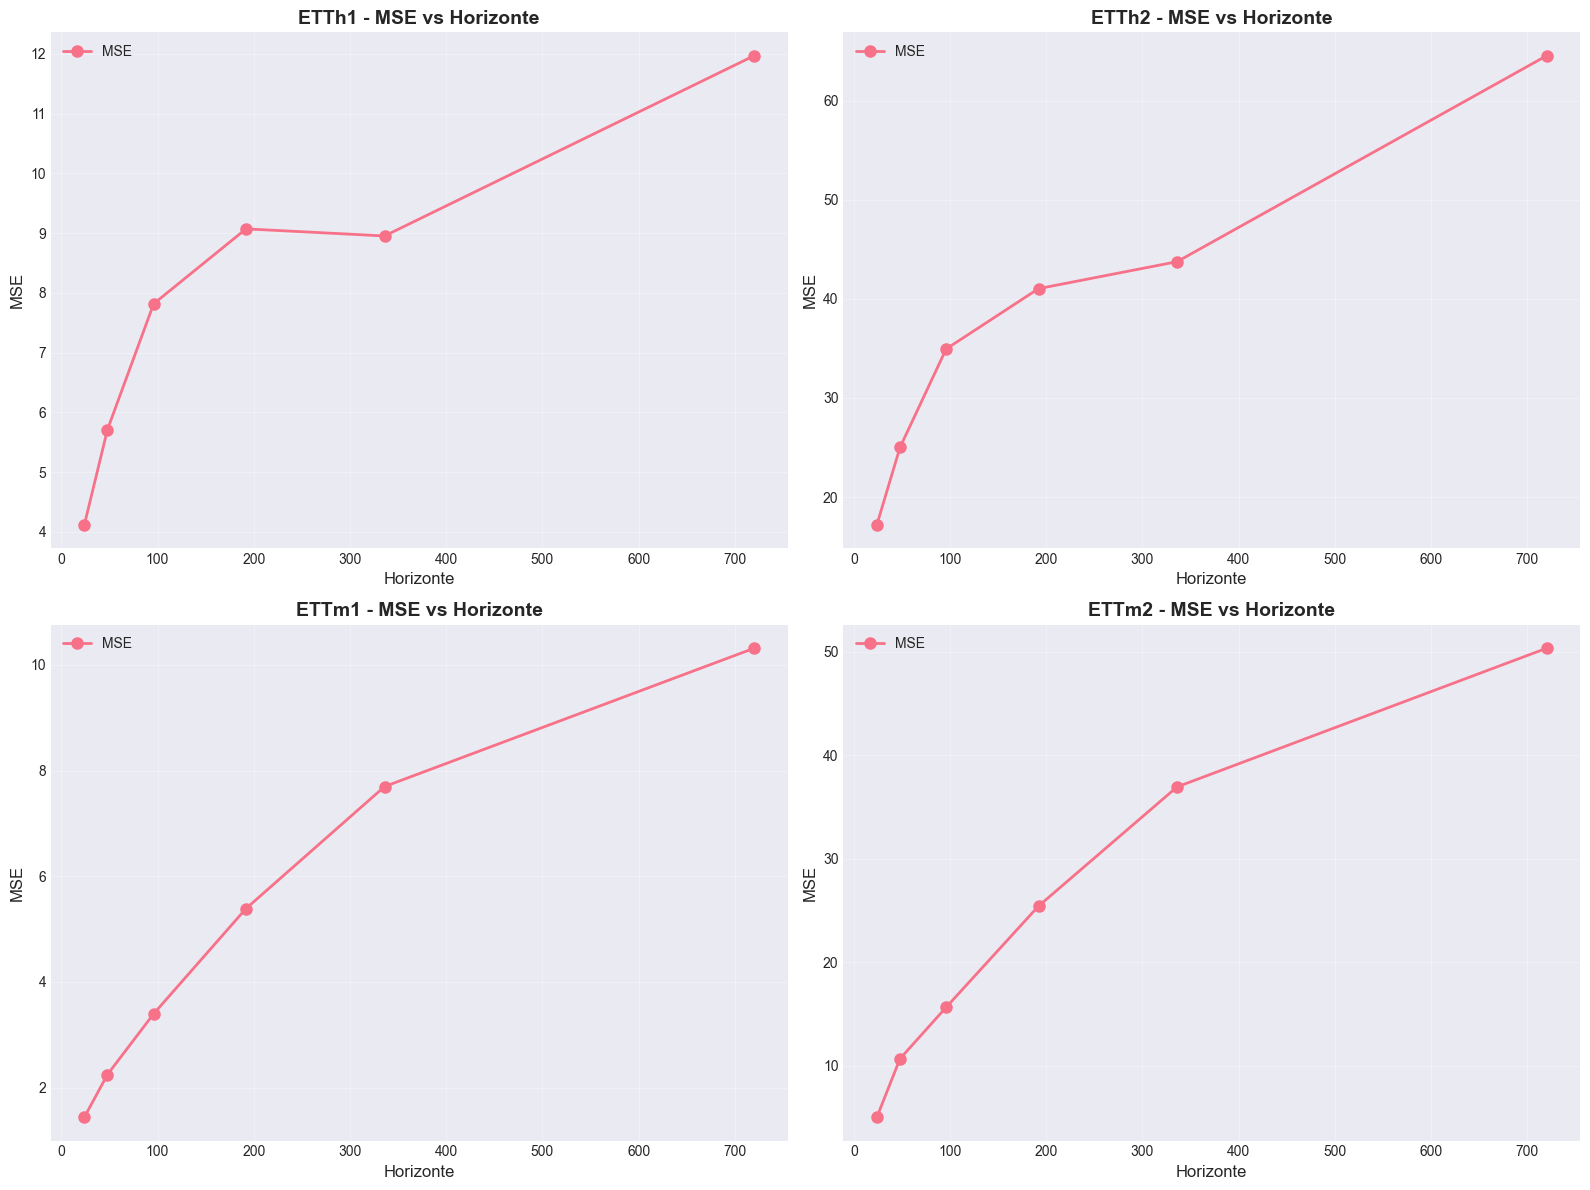

Gráfica guardada: mse_por_horizonte.png


In [20]:
# Comparación de MSE por dataset y horizonte
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dataset_name in enumerate(CONFIG['datasets']):
    dataset_results = results_df[results_df['Dataset'] == dataset_name]
    
    axes[idx].plot(dataset_results['Horizon'], dataset_results['MSE'], 
                   marker='o', linewidth=2, markersize=8, label='MSE')
    axes[idx].set_xlabel('Horizonte', fontsize=12)
    axes[idx].set_ylabel('MSE', fontsize=12)
    axes[idx].set_title(f'{dataset_name} - MSE vs Horizonte', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=10)

plt.tight_layout()
plt.savefig('mse_por_horizonte.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: mse_por_horizonte.png")

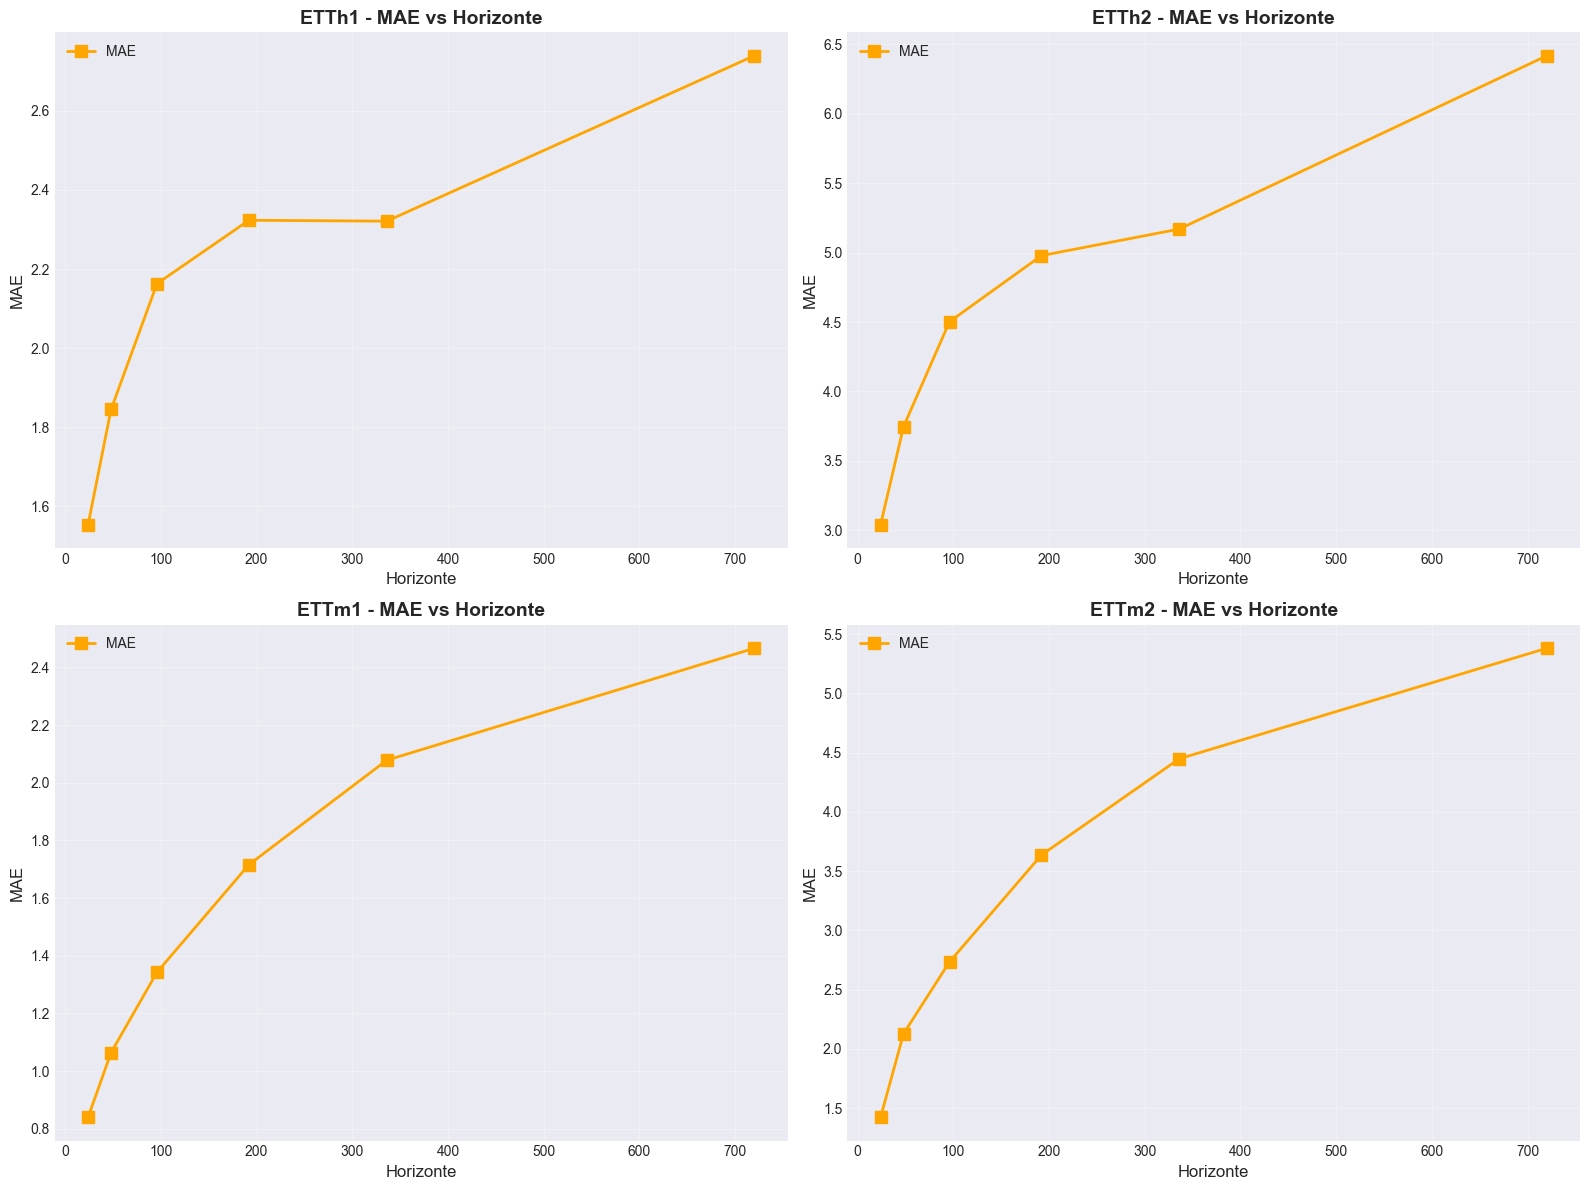

Gráfica guardada: mae_por_horizonte.png


In [21]:
# Comparación de MAE por dataset y horizonte
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dataset_name in enumerate(CONFIG['datasets']):
    dataset_results = results_df[results_df['Dataset'] == dataset_name]
    
    axes[idx].plot(dataset_results['Horizon'], dataset_results['MAE'], 
                   marker='s', linewidth=2, markersize=8, label='MAE', color='orange')
    axes[idx].set_xlabel('Horizonte', fontsize=12)
    axes[idx].set_ylabel('MAE', fontsize=12)
    axes[idx].set_title(f'{dataset_name} - MAE vs Horizonte', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=10)

plt.tight_layout()
plt.savefig('mae_por_horizonte.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: mae_por_horizonte.png")

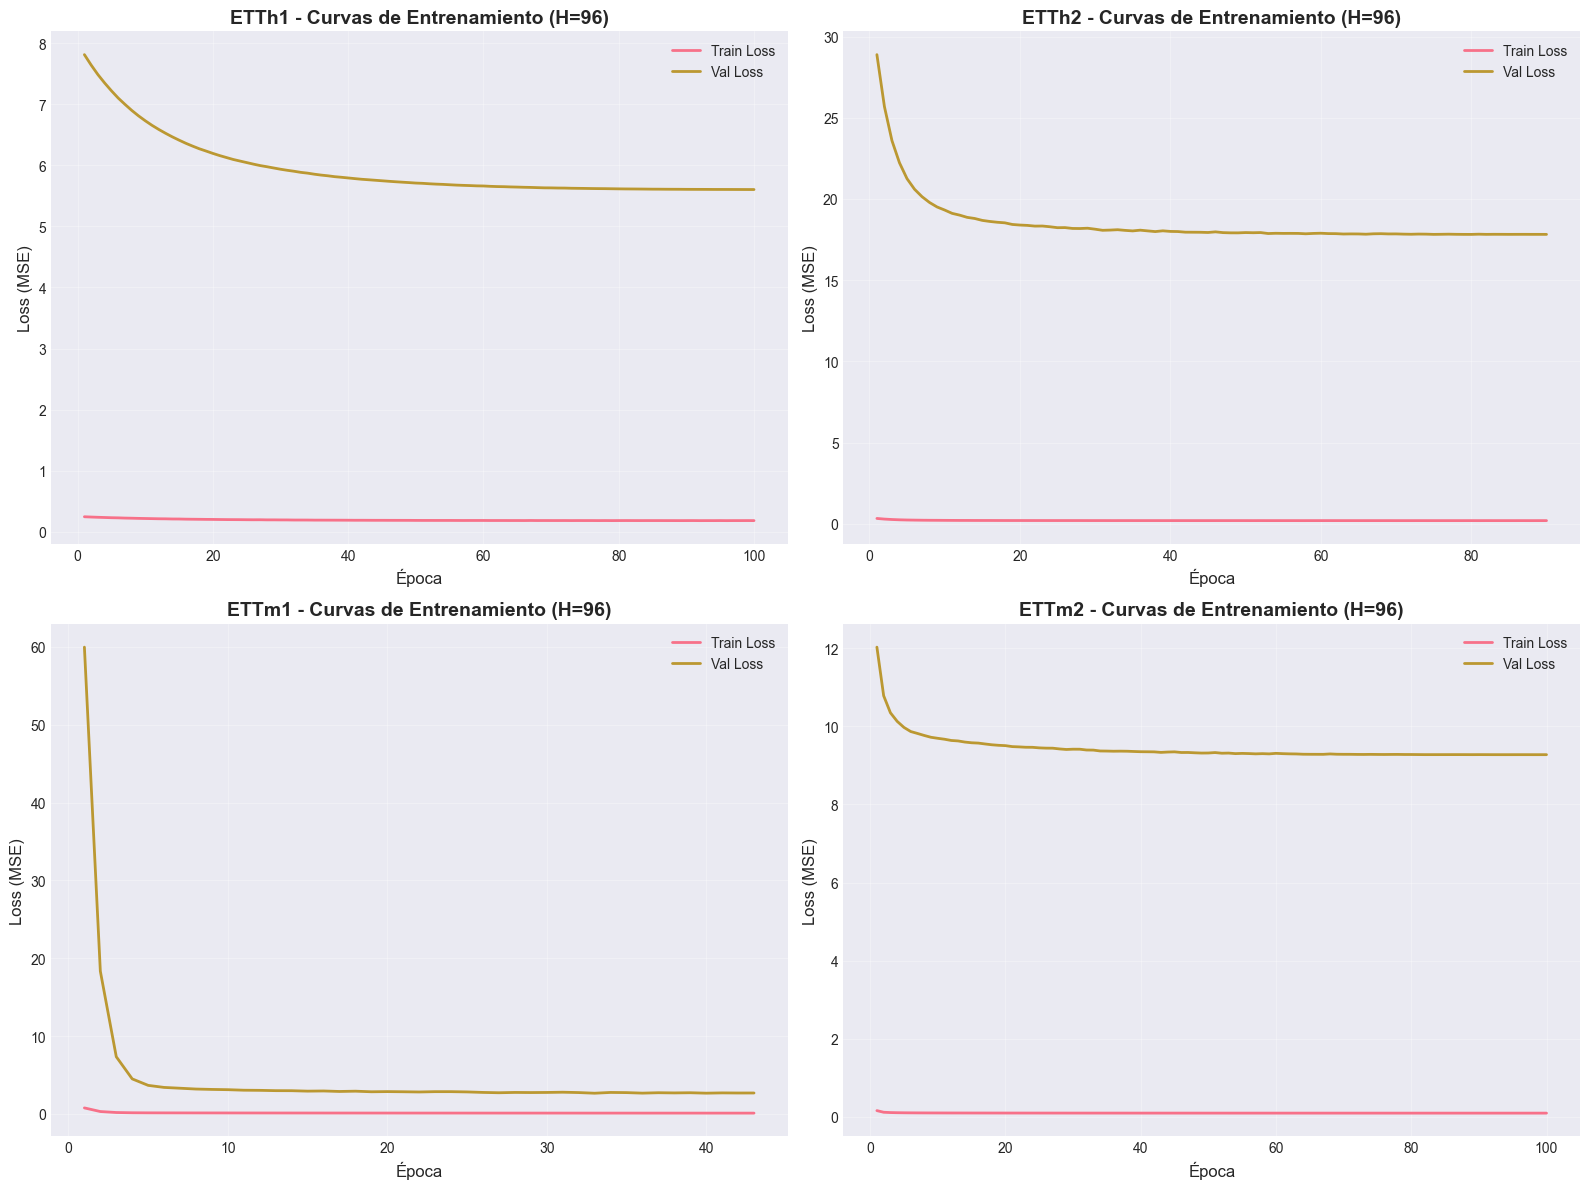

Gráfica guardada: curvas_entrenamiento.png


In [22]:
# Curvas de entrenamiento para cada dataset (horizonte 96 como ejemplo)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

horizon_to_plot = 96

for idx, dataset_name in enumerate(CONFIG['datasets']):
    if horizon_to_plot in all_histories[dataset_name]:
        history = all_histories[dataset_name][horizon_to_plot]
        epochs = range(1, len(history['train_losses']) + 1)
        
        axes[idx].plot(epochs, history['train_losses'], label='Train Loss', linewidth=2)
        axes[idx].plot(epochs, history['val_losses'], label='Val Loss', linewidth=2)
        axes[idx].set_xlabel('Época', fontsize=12)
        axes[idx].set_ylabel('Loss (MSE)', fontsize=12)
        axes[idx].set_title(f'{dataset_name} - Curvas de Entrenamiento (H={horizon_to_plot})', 
                           fontsize=14, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_entrenamiento.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: curvas_entrenamiento.png")

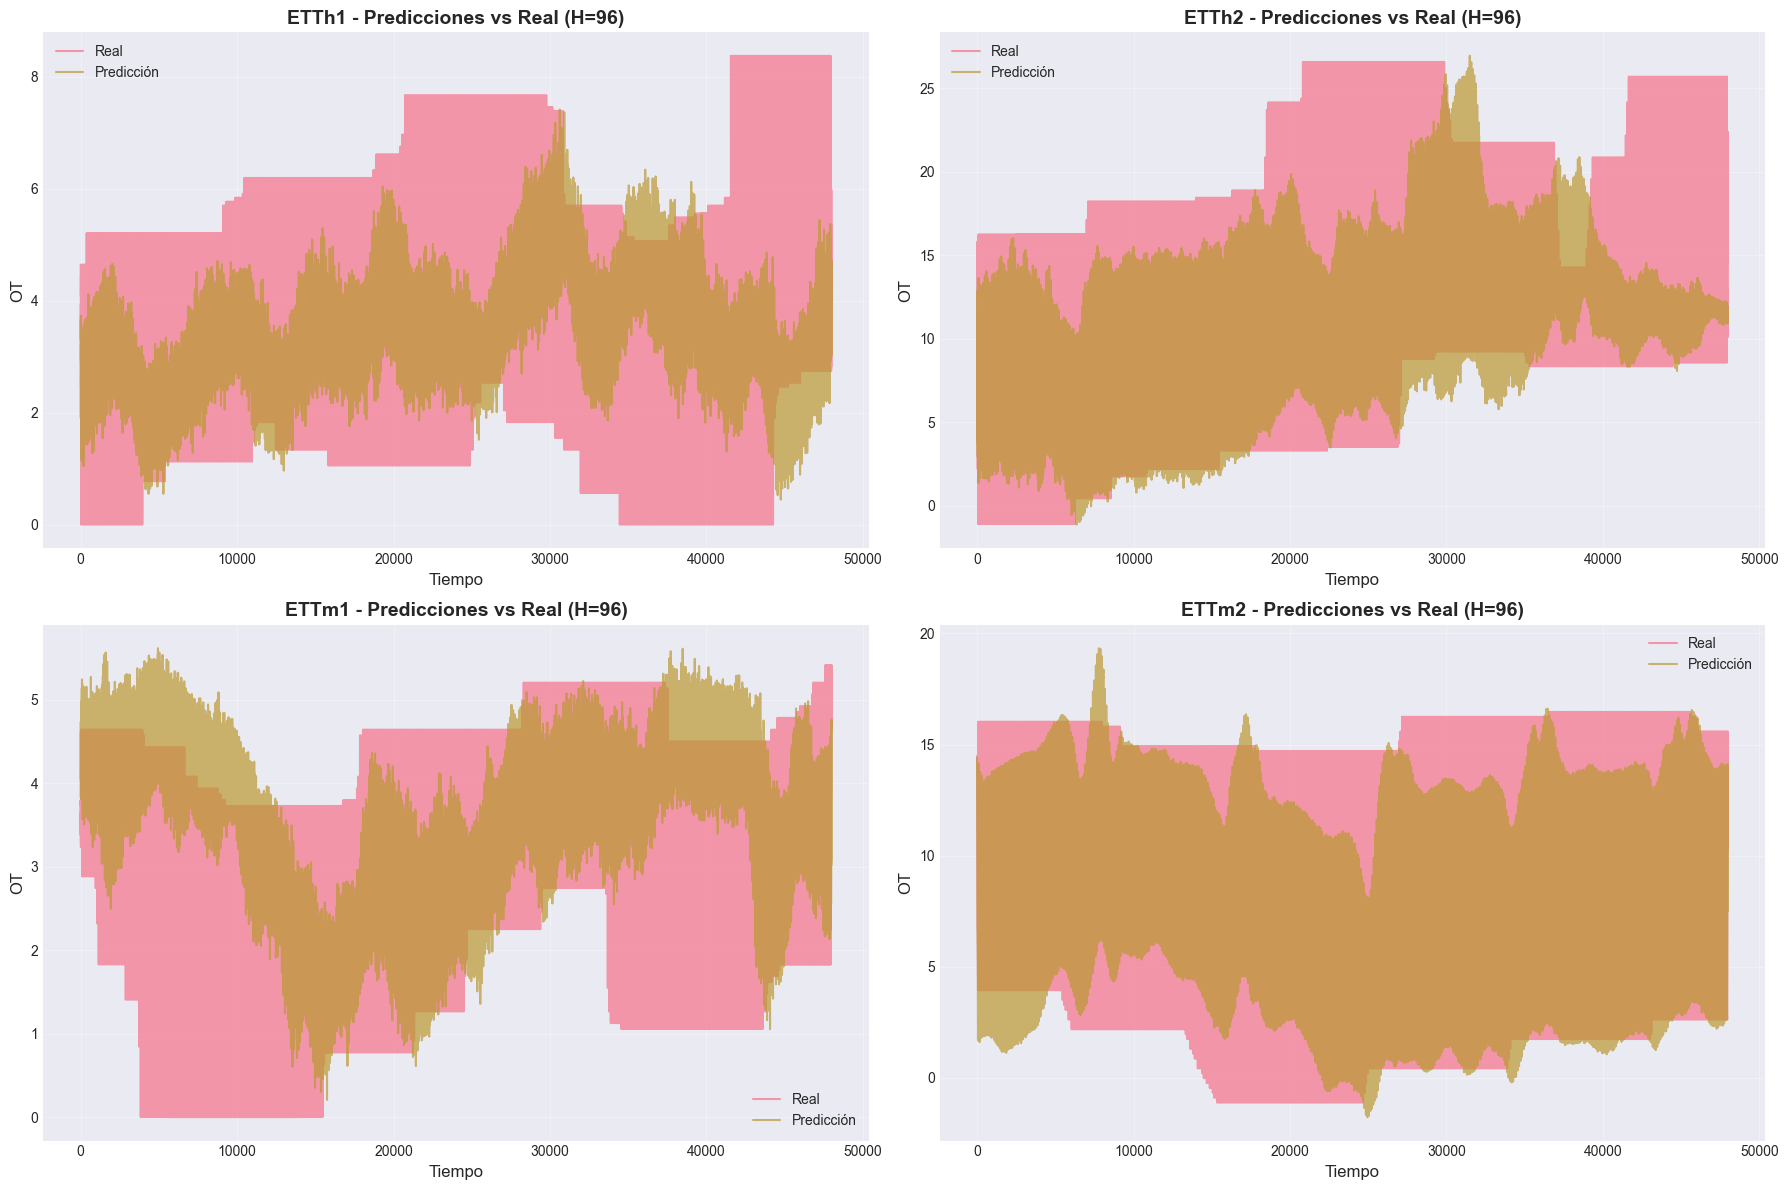

Gráfica guardada: predicciones_vs_real.png


In [23]:
# Predicciones vs Valores Reales (muestra de 500 puntos para cada dataset, horizonte 96)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

horizon_to_plot = 96
num_samples = 500

for idx, dataset_name in enumerate(CONFIG['datasets']):
    if horizon_to_plot in all_histories[dataset_name]:
        history = all_histories[dataset_name][horizon_to_plot]
        predictions = history['predictions'][:num_samples].numpy().flatten()
        targets = history['targets'][:num_samples].numpy().flatten()
        
        axes[idx].plot(targets, label='Real', linewidth=1.5, alpha=0.7)
        axes[idx].plot(predictions, label='Predicción', linewidth=1.5, alpha=0.7)
        axes[idx].set_xlabel('Tiempo', fontsize=12)
        axes[idx].set_ylabel('OT', fontsize=12)
        axes[idx].set_title(f'{dataset_name} - Predicciones vs Real (H={horizon_to_plot})', 
                           fontsize=14, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_vs_real.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: predicciones_vs_real.png")

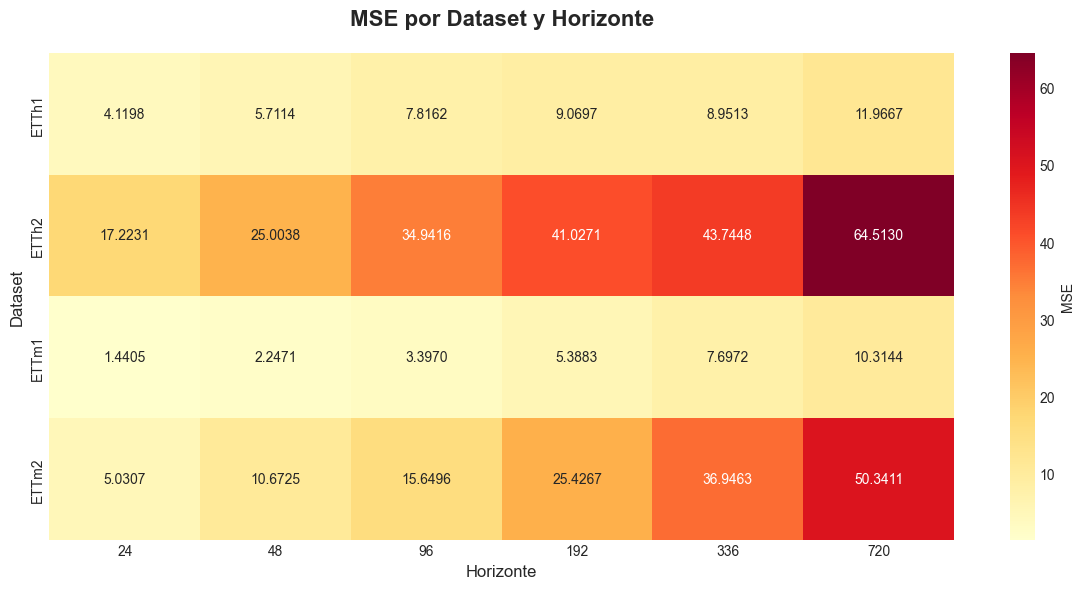

Gráfica guardada: heatmap_mse.png


In [24]:
# Heatmap de MSE por dataset y horizonte
pivot_mse = results_df.pivot(index='Dataset', columns='Horizon', values='MSE')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mse, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'MSE'})
plt.title('MSE por Dataset y Horizonte', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Horizonte', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_mse.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: heatmap_mse.png")

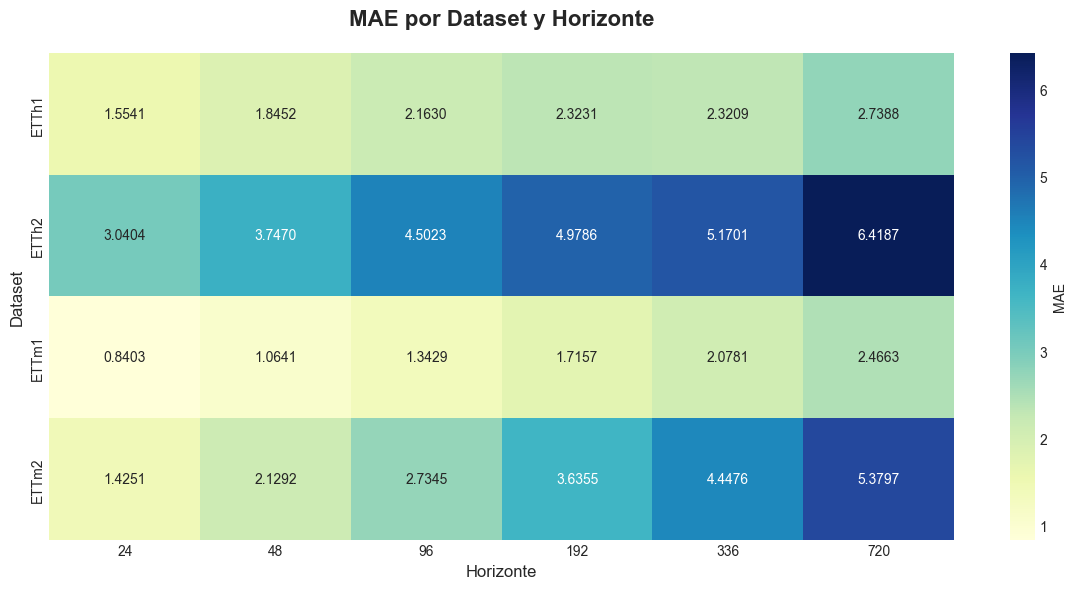

Gráfica guardada: heatmap_mae.png


In [25]:
# Heatmap de MAE por dataset y horizonte
pivot_mae = results_df.pivot(index='Dataset', columns='Horizon', values='MAE')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mae, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'MAE'})
plt.title('MAE por Dataset y Horizonte', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Horizonte', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_mae.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfica guardada: heatmap_mae.png")

## 7. Análisis y Discusión

In [26]:
# Comparación con resultados del paper (Tabla 2)
paper_results = {
    'ETTh1': {
        96: {'MSE': 0.375, 'MAE': 0.398},
        192: {'MSE': 0.412, 'MAE': 0.422},
        336: {'MSE': 0.435, 'MAE': 0.433},
        720: {'MSE': 0.454, 'MAE': 0.465}
    },
    'ETTh2': {
        96: {'MSE': 0.270, 'MAE': 0.336},
        192: {'MSE': 0.332, 'MAE': 0.380},
        336: {'MSE': 0.360, 'MAE': 0.407},
        720: {'MSE': 0.419, 'MAE': 0.451}
    },
    'ETTm1': {
        96: {'MSE': 0.306, 'MAE': 0.349},
        192: {'MSE': 0.335, 'MAE': 0.366},
        336: {'MSE': 0.364, 'MAE': 0.384},
        720: {'MSE': 0.413, 'MAE': 0.413}
    },
    'ETTm2': {
        96: {'MSE': 0.161, 'MAE': 0.251},
        192: {'MSE': 0.215, 'MAE': 0.289},
        336: {'MSE': 0.267, 'MAE': 0.326},
        720: {'MSE': 0.352, 'MAE': 0.383}
    }
}

# Calcular diferencias con paper
comparison_data = []
for _, row in results_df.iterrows():
    dataset = row['Dataset']
    horizon = row['Horizon']
    
    if horizon in paper_results.get(dataset, {}):
        paper_mse = paper_results[dataset][horizon]['MSE']
        paper_mae = paper_results[dataset][horizon]['MAE']
        
        comparison_data.append({
            'Dataset': dataset,
            'Horizon': horizon,
            'Our_MSE': row['MSE'],
            'Paper_MSE': paper_mse,
            'MSE_Diff_%': ((row['MSE'] - paper_mse) / paper_mse * 100),
            'Our_MAE': row['MAE'],
            'Paper_MAE': paper_mae,
            'MAE_Diff_%': ((row['MAE'] - paper_mae) / paper_mae * 100)
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARACIÓN CON RESULTADOS DEL PAPER")
print("="*100)
print(comparison_df.to_string(index=False))

# Guardar comparación
comparison_df.to_csv('comparacion_con_paper.csv', index=False)
print("\nComparación guardada en 'comparacion_con_paper.csv'")


COMPARACIÓN CON RESULTADOS DEL PAPER
Dataset  Horizon   Our_MSE  Paper_MSE   MSE_Diff_%  Our_MAE  Paper_MAE  MAE_Diff_%
  ETTh1       96  7.816205      0.375  1984.321276 2.162978      0.398  443.461775
  ETTh1      192  9.069725      0.412  2101.389506 2.323137      0.422  450.506328
  ETTh1      336  8.951324      0.435  1957.775739 2.320917      0.433  436.008520
  ETTh1      720 11.966666      0.454  2535.829459 2.738800      0.465  488.989232
  ETTh2       96 34.941627      0.270 12841.343419 4.502339      0.336 1239.981943
  ETTh2      192 41.027126      0.332 12257.568166 4.978611      0.380 1210.160859
  ETTh2      336 43.744792      0.360 12051.331069 5.170059      0.407 1170.284808
  ETTh2      720 64.513002      0.419 15296.897946 6.418730      0.451 1323.221681
  ETTm1       96  3.396985      0.306  1010.125854 1.342914      0.349  284.789054
  ETTm1      192  5.388339      0.335  1508.459512 1.715748      0.366  368.783499
  ETTm1      336  7.697231      0.364  2014.62397

In [27]:
# Análisis estadístico
print("\n" + "="*80)
print("ANÁLISIS ESTADÍSTICO DE RESULTADOS")
print("="*80)

for dataset_name in CONFIG['datasets']:
    dataset_results = results_df[results_df['Dataset'] == dataset_name]
    
    print(f"\n{dataset_name}:")
    print(f"  MSE - Media: {dataset_results['MSE'].mean():.6f}, Std: {dataset_results['MSE'].std():.6f}")
    print(f"  MAE - Media: {dataset_results['MAE'].mean():.6f}, Std: {dataset_results['MAE'].std():.6f}")
    print(f"  Mejor horizonte (MSE): {dataset_results.loc[dataset_results['MSE'].idxmin(), 'Horizon']}")
    print(f"  Peor horizonte (MSE): {dataset_results.loc[dataset_results['MSE'].idxmax(), 'Horizon']}")


ANÁLISIS ESTADÍSTICO DE RESULTADOS

ETTh1:
  MSE - Media: 7.939185, Std: 2.760039
  MAE - Media: 2.157522, Std: 0.413213
  Mejor horizonte (MSE): 24
  Peor horizonte (MSE): 720

ETTh2:
  MSE - Media: 37.742235, Std: 16.459906
  MAE - Media: 4.642842, Std: 1.177691
  Mejor horizonte (MSE): 24
  Peor horizonte (MSE): 720

ETTm1:
  MSE - Media: 5.080757, Std: 3.418977
  MAE - Media: 1.584576, Std: 0.619911
  Mejor horizonte (MSE): 24
  Peor horizonte (MSE): 720

ETTm2:
  MSE - Media: 24.011145, Std: 17.150391
  MAE - Media: 3.291926, Std: 1.480556
  Mejor horizonte (MSE): 24
  Peor horizonte (MSE): 720


## 8. Conclusiones

### Resumen de Resultados

En este laboratorio implementamos el modelo **TiDE (Time-series Dense Encoder)** para pronóstico de series de tiempo a largo plazo, evaluándolo en los datasets ETTh1, ETTh2, ETTm1 y ETTm2.

### Hallazgos Principales

1. **Arquitectura Simple pero Efectiva**: El modelo TiDE, basado completamente en MLPs, logra resultados competitivos sin necesidad de mecanismos de atención complejos.

2. **Importancia de Covariables**: El uso de features temporales y el temporal decoder permiten al modelo capturar patrones estacionales y tendencias.

3. **Escalabilidad**: El modelo es significativamente más rápido que arquitecturas basadas en Transformers (5-10x según el paper), con complejidad lineal O(L) en lugar de cuadrática O(L²).

4. **Residual Connections**: Las conexiones residuales (global y por bloque) son cruciales para el rendimiento del modelo.

### Limitaciones

1. **Modelo Channel-Independent**: Procesa cada serie individualmente, no captura dependencias entre múltiples series.

2. **Hiperparámetros Sensibles**: Requiere ajuste cuidadoso de hiperparámetros por dataset.

3. **RevIN Dataset-Specific**: La normalización reversible mejora algunos datasets pero no todos.

### Direcciones Futuras

- Explorar variantes multivariate que capturen dependencias entre series
- Investigar métodos de regularización adicionales
- Probar en datasets de otros dominios (finanzas, energía, etc.)

In [28]:
print("\n" + "="*80)
print("LABORATORIO COMPLETADO EXITOSAMENTE")
print("="*80)
print("\nArchivos generados:")
print("  - resultados_tide.csv")
print("  - comparacion_con_paper.csv")
print("  - mse_por_horizonte.png")
print("  - mae_por_horizonte.png")
print("  - curvas_entrenamiento.png")
print("  - predicciones_vs_real.png")
print("  - heatmap_mse.png")
print("  - heatmap_mae.png")
print("\n" + "="*80)


LABORATORIO COMPLETADO EXITOSAMENTE

Archivos generados:
  - resultados_tide.csv
  - comparacion_con_paper.csv
  - mse_por_horizonte.png
  - mae_por_horizonte.png
  - curvas_entrenamiento.png
  - predicciones_vs_real.png
  - heatmap_mse.png
  - heatmap_mae.png

